# Note:
- This notebook file may contain methods or algorithms that are NOT covered by the teaching content of BT4222 and hence will not be assessed in your midterm exam.
- It serves to increase your exposure in depth and breath to the practical methods in addressing the specific project topic. We believe it will be helpful for your current project and also your future internship endeavors.

# Enhanced Credit Card Fraud Detection based on Attention mechanism and LSTM deep Model
The purpose of this project is to develop a novel system for credit card fraud detection based on sequential modeling of data, using Attention mechanism and LSTM deep recurrent neural networks. The method and code came from the paper [Enhanced Credit Card Fraud Detection based on Attention mechanism and LSTM deep Model](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00541-8) and its [github](https://github.com/bibtissam/LSTM-Attention-FraudDetection/tree/main).

## Architecture
The architecture of the model is illustrated by the following.


<img src="https://github.com/bibtissam/LSTM-Attention-FraudDetection/blob/main/img/4.png?raw=true" alt="Architecture"
	title="Architecture pic" width="500" height="300" />

## Agenda
1. Credit Card Fraud Dataset and feature selection
2. Dimensionality reduction
3. LSTM
4. Attention mechanism

## Feature selection
The authors employed [Swarm intelligence based feature selection approach](https://www.mdpi.com/2076-3417/8/9/1521) to perform feature seletcion.

Some dimension reduction algorithms such as PCA, t-SNE and UMAP are also mentioned in the paper. Here are some reference that you can get to know the algorithms if interested: [PCA](https://en.wikipedia.org/wiki/Principal_component_analysis), [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), [UMAP](https://umap-learn.readthedocs.io/en/latest/)

## Part 1: Credit Card Fraud Dataset and feature selection
- Target: data preprocessing for credit card fraud detection task
  - Loads a dataset from a specified CSV file related to credit card transactions
  - Drops a list of specified columns from the dataset that are deemed unnecessary for the task

In [ ]:
import pandas as pd
import sklearn.metrics as metrique
from pandas import Series
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.utils import np_utils
from keras.layers import LSTM, Dense, Embedding, Dropout,Input, Attention, Layer, Concatenate, Permute, Dot, Multiply, Flatten
from keras.layers import RepeatVector, Dense, Activation, Lambda
from keras.models import Sequential
from keras import backend as K, regularizers, Model, metrics
from keras.backend import cast

In [ ]:
from google.colab import drive

import gdown

file_id = '1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'creditcard_small.csv'
gdown.download(url, output, quiet=False)

data = pd.read_csv('creditcard_small.csv', na_filter=True)
col_del = ['Time' ,'V5', 'V6', 'V7', 'V8', 'V9','V13','V15', 'V16',  'V18', 'V19', 'V20','V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Downloading...
From: https://drive.google.com/uc?id=1s3P67dsOL0Hh538zuiV0dS8fYYM-8sGd
To: /content/creditcard_small.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 49.1MB/s]


In [ ]:
tr_data = data.drop(col_del,axis =1)
tr_data.shape

(19999, 10)

In [ ]:
X = tr_data.drop(['Class'], axis = 'columns')
Label_Data = tr_data['Class']

In [ ]:
# Generate and plot imbalanced classification dataset
from collections import Counter
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(tr_data['Class'])
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(tr_data['Class'] == label)[0]

Counter({0: 19914, 1: 85})


## Part 2: Dimensionality reduction
- Target: handle class imbalance in the dataset and splitting it for training and testing
  - Imports the necessary SMOTE class for handling class imbalance
  - Applies the SMOTE technique to the feature matrix and target series, creating an oversampled feature matrix and target series
  - Standardizes the features in the oversampled feature matrix, resulting in a new feature matrix with zero mean and unit variance for each feature
  - Splits the standardized feature matrix and target series into training and testing sets, with a test set size of 30%

In [ ]:
# transform the dataset
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_r, y = oversample.fit_resample(X, tr_data['Class'])
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]

Counter({0: 19914, 1: 19914})


In [ ]:
from sklearn.preprocessing import StandardScaler
## Standardizing the data
X_r2 = StandardScaler().fit_transform(X_r)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_r2, y, test_size=0.3)

In [ ]:
X_train.shape

(27879, 9)

In [ ]:
X_test.shape

(11949, 9)

## Part 3: LSTM
- Target: use a Long Short-Term Memory (LSTM) model to train and test on a credit card fraud dataset, and evaluates and visualizes the performance of the model
  - Set a seed for the random number generator for repeatability
  - Reshape the input datasets to the format required by LSTM and sets the target variables
  - Define and compiles the LSTM model for binary classification
  - Train the model on the training data, validates it on the test data, and saves the trained model to disk
  - Load the saved model, prints its structure, and evaluates its performance on the training and test datasets
  - Plot the history of loss and accuracy during training for both training and test datasets
  - Transform the model's predictions on the test dataset back into class labels, and calculates various performance metrics
  - Define a function to plot a confusion matrix and uses it to plot the confusion matrix for the LSTM model's predictions.

In [ ]:
np.random.seed(7)

# X_train et X_val
train_LSTM_X=X_train
val_LSTM_X=X_test

## Reshape input to be 3D [samples, timesteps, features]
train_LSTM_X = train_LSTM_X.reshape((train_LSTM_X.shape[0], 1, train_LSTM_X.shape[1]))
val_LSTM_X = val_LSTM_X.reshape((val_LSTM_X.shape[0], 1, val_LSTM_X.shape[1]))

train_LSTM_y=y_train
val_LSTM_y=y_test

In [ ]:
inputs=Input((1,9))
x1=LSTM(50,dropout=0.3,recurrent_dropout=0.2,return_sequences=True)(inputs)
x2=LSTM(50,dropout=0.3,recurrent_dropout=0.2)(x1)
outputs=Dense(1,activation='sigmoid')(x2)
model=Model(inputs,outputs)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history=model.fit(train_LSTM_X, train_LSTM_y,epochs=100,batch_size=20000, validation_data=(val_LSTM_X, val_LSTM_y))
model.save('Save_Model.h5')
print("Saved model to disk")

Epoch 1/100
2/2 [==============================] - 13s 2s/step - loss: 0.6971 - accuracy: 0.2933 - val_loss: 0.6919 - val_accuracy: 0.7040
Epoch 2/100
2/2 [==============================] - 1s 303ms/step - loss: 0.6913 - accuracy: 0.5760 - val_loss: 0.6858 - val_accuracy: 0.8150
Epoch 3/100
2/2 [==============================] - 1s 224ms/step - loss: 0.6854 - accuracy: 0.7664 - val_loss: 0.6795 - val_accuracy: 0.8400
Epoch 4/100
2/2 [==============================] - 1s 250ms/step - loss: 0.6794 - accuracy: 0.8239 - val_loss: 0.6731 - val_accuracy: 0.8689
Epoch 5/100
2/2 [==============================] - 0s 133ms/step - loss: 0.6732 - accuracy: 0.8461 - val_loss: 0.6663 - val_accuracy: 0.8765
Epoch 6/100
2/2 [==============================] - 0s 139ms/step - loss: 0.6668 - accuracy: 0.8587 - val_loss: 0.6592 - val_accuracy: 0.8838
Epoch 7/100
2/2 [==============================] - 0s 129ms/step - loss: 0.6599 - accuracy: 0.8667 - val_loss: 0.6515 - val_accuracy: 0.8911
Epoch 8/100
2/2

In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

# load model
model = load_model('Save_Model.h5')
# summarize model.
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 9)]            0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             12000     
                                                                 
 lstm_3 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,251
Trainable params: 32,251
Non-trainable params: 0
_________________________________________________________________


In [ ]:
_, train_acc = model.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.962, Test: 0.962


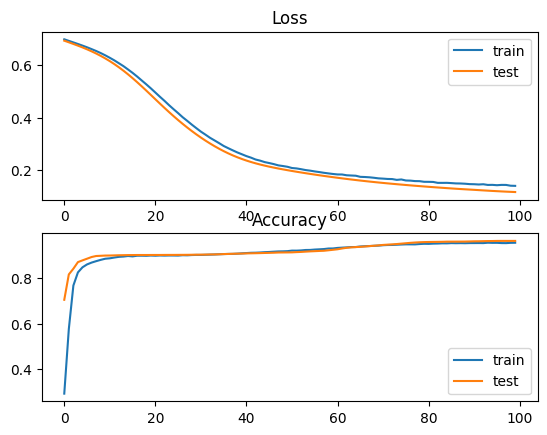

In [ ]:
# plot loss during training
pyplot.subplot(211)
pyplot.title('Loss')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
# plot accuracy during training
pyplot.subplot(212)
pyplot.title('Accuracy')
pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# predict probabilities for test set
yhat_probs = model.predict(val_LSTM_X, verbose=0)
# transform predicted probabilities back to class labels before calculating the classification metrics
yhat_probs = yhat_probs.flatten()
yhat_probs = np.where(yhat_probs > 0.5, 1, 0)

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_probs)
print('Recall: %f' % recall)

Accuracy: 0.961587
Precision: 0.998019
Recall: 0.925221


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_probs)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
labels = ['Normal','Fraud']

Confusion matrix, without normalization
[[5947   11]
 [ 448 5543]]


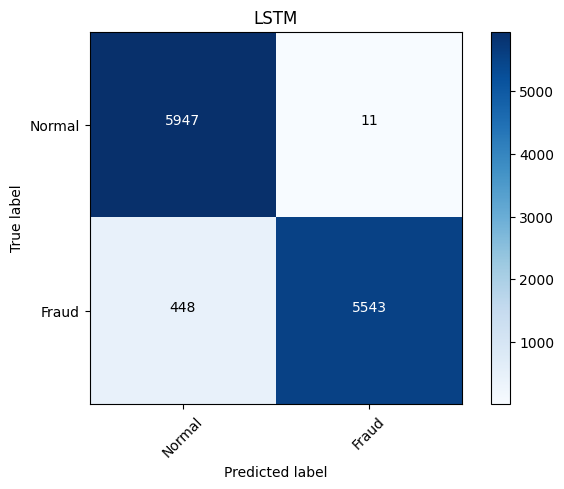

In [ ]:
plot_confusion_matrix(cm=cm, classes=labels, title='LSTM')

## Part 4: Attension Mechanism
- Target: define and implement an Attention mechanism class within a Long Short-Term Memory (LSTM) neural network model for the credit card fraud detection task
  - The Attention mechanism is defined as a Keras Layer with parameters for weights and biases. The attention weights are calculated using a tanh activation function applied on the dot product of input and weight, and a softmax activation function to convert it into probabilities. This allows the model to focus on specific parts of the sequence.
  - The input data is passed through two LSTM layers with dropout and recurrent dropout for preventing overfitting.
  - The output from the second LSTM layer is passed to the attention layer which computes the context vector by taking the weighted sum of the LSTM output (element-wise multiplication with attention weights).
  - The output of the attention layer is then fed to a dense layer with a sigmoid activation function which outputs the probability of a transaction being fraudulent.
  - The model is then compiled with 'binary_crossentropy' loss function, 'adam' optimizer and 'accuracy' as the metric.
  - The model is trained with the training data and validated with the validation data.
  - The model is then saved and can be loaded again with the custom Attention layer.
  - The model's summary, training and testing accuracy are printed.
  - The model's predictions are made on the validation data, which are then used to calculate performance metrics - accuracy, precision, and recall.
  - Finally, a confusion matrix of the model's predictions is created for further evaluation of the model's performance.

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
inputs1=Input((1,9))
att_in=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(inputs1)
att_in_1=LSTM(50,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(att_in)
att_out=attention()(att_in_1)
outputs1=Dense(1,activation='sigmoid',trainable=True)(att_out)
model1=Model(inputs1,outputs1)

In [ ]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history1=model1.fit(train_LSTM_X, train_LSTM_y,epochs=200,batch_size=30000, validation_data=(val_LSTM_X, val_LSTM_y))

Epoch 1/200
1/1 [==============================] - 6s 6s/step - loss: 0.7044 - accuracy: 0.1230 - val_loss: 0.7019 - val_accuracy: 0.1027
Epoch 2/200
1/1 [==============================] - 0s 404ms/step - loss: 0.7014 - accuracy: 0.1512 - val_loss: 0.6988 - val_accuracy: 0.1077
Epoch 3/200
1/1 [==============================] - 0s 386ms/step - loss: 0.6985 - accuracy: 0.2175 - val_loss: 0.6957 - val_accuracy: 0.1613
Epoch 4/200
1/1 [==============================] - 0s 402ms/step - loss: 0.6956 - accuracy: 0.3556 - val_loss: 0.6927 - val_accuracy: 0.5959
Epoch 5/200
1/1 [==============================] - 0s 403ms/step - loss: 0.6927 - accuracy: 0.5253 - val_loss: 0.6897 - val_accuracy: 0.8338
Epoch 6/200
1/1 [==============================] - 0s 396ms/step - loss: 0.6899 - accuracy: 0.6833 - val_loss: 0.6868 - val_accuracy: 0.8498
Epoch 7/200
1/1 [==============================] - 0s 413ms/step - loss: 0.6871 - accuracy: 0.7821 - val_loss: 0.6838 - val_accuracy: 0.8658
Epoch 8/200
1/1 

In [ ]:
model1.save('Save_Model_Attention.h5')
print("Saved model to disk")

Saved model to disk


In [ ]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model

# load model
# model1 = load_model('Save_Model_Attention.h5')
model1 = load_model('Save_Model_Attention.h5', custom_objects={'attention': attention})
# summarize model.
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 9)]            0         
                                                                 
 lstm_4 (LSTM)               (None, 1, 50)             12000     
                                                                 
 lstm_5 (LSTM)               (None, 1, 50)             20200     
                                                                 
 attention (attention)       (None, 50)                51        
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 32,302
Trainable params: 32,302
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# evaluate the model
_, train_acc = model1.evaluate(train_LSTM_X, train_LSTM_y, verbose=0)
_, test_acc = model1.evaluate(val_LSTM_X, val_LSTM_y, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

Train: 0.962, Test: 0.962


In [ ]:
# predict probabilities for test set
yhat_probs1 = model1.predict(val_LSTM_X, verbose=0)
# reduce to 1d array
# yhat_probs1 = yhat_probs1[:, 0]
yhat_probs1 = yhat_probs1.flatten()
yhat_probs1 = np.where(yhat_probs1 > 0.5, 1, 0)

In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_LSTM_y, yhat_probs1)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_probs1)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_probs1)
print('Recall: %f' % recall)

Accuracy: 0.961587
Precision: 0.998019
Recall: 0.925221


In [ ]:
# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(val_LSTM_y, yhat_probs)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(val_LSTM_y, yhat_probs)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(val_LSTM_y, yhat_probs)
print('Recall: %f' % recall)

Accuracy: 0.961587
Precision: 0.998019
Recall: 0.925221


In [ ]:
cm1 = confusion_matrix(y_true=val_LSTM_y, y_pred=yhat_probs1)

Confusion matrix, without normalization
[[5947   11]
 [ 448 5543]]


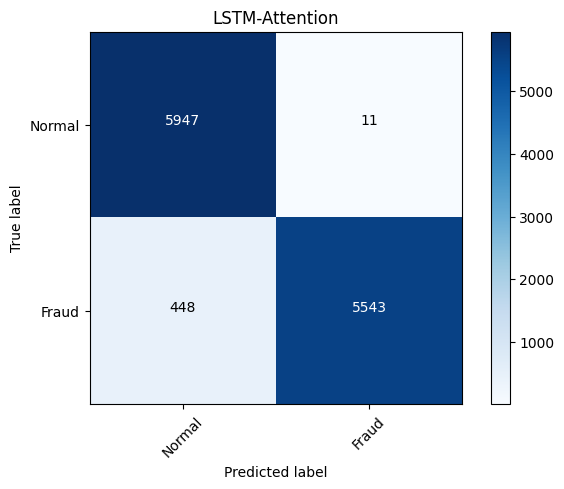

In [ ]:
plot_confusion_matrix(cm=cm1, classes=labels, title='LSTM-Attention', normalize=False)